### Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.decomposition import PCA


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SKRIPSI/Data Mentah.csv')

In [3]:
# df

Jumlah baris: 405 baris

Jumlah kolom: 20 kolom

Atribut: 
*   NPM digunakan untuk mencari angkatan (14, 15, 16)
*   Tempat lahir untuk mencari asal (kolom baru) : surabaya, luar surabaya
*   tanggal lahir lahir untuk mencari usia (kolom baru): tgl semester 6 - tgl lahir
*   Baris organisasi yang nggak kosong, diisi dengan 'Tidak'
*   Tanggal yudisium untuk mencari keputusan (kolom baru): tgl yudisum > tgl batas yudisium

Atribut yang dihapus:
NPM, tempat lahir, tanggal lahir, tanggal yudisium

Atribut yang ada:
Jurusan, jenis kelamin, usia, asal, jalur masuk, golongan ukt, organisasi, IPS 1-5, SKS 1-6, Keputusan







### Data Preparation

In [4]:
df.dtypes

NPM                   int64
Jenis Kelamin        object
Tempat Lahir         object
Tanggal Lahir        object
Jalur Masuk          object
Jurusan              object
Golongan UKT          int64
Organisasi           object
IPS 1               float64
IPS 2               float64
IPS 3               float64
IPS 4               float64
IPS 5               float64
SKS 1                 int64
SKS 2                 int64
SKS 3                 int64
SKS 4                 int64
SKS 5                 int64
SKS 6                 int64
Tanggal Yudisium     object
dtype: object

In [5]:
df.shape

(405, 20)

In [6]:
df.describe()

,NPM,Golongan UKT,IPS 1,IPS 2,IPS 3,IPS 4,IPS 5,SKS 1,SKS 2,SKS 3,SKS 4,SKS 5,SKS 6
count,4.050000e+02,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000
mean,1.513874e+09,3.560494,3.346642,3.433699,3.489812,3.536314,3.518521,19.496296,22.195062,22.533333,22.335802,22.360494,21.219753
std,7.750325e+07,2.046349,0.338034,0.377587,0.294599,0.344155,0.321496,0.788601,1.275813,1.146238,1.134878,1.526473,2.762659
min,1.434010e+09,1.000000,0.475000,0.592000,1.818000,0.815000,1.938000,18.000000,15.000000,14.000000,13.000000,13.000000,10.000000
25%,1.434010e+09,2.000000,3.188000,3.298000,3.293000,3.369000,3.365000,19.000000,21.000000,23.000000,22.000000,22.000000,19.000000
50%,1.534010e+09,3.000000,3.382000,3.511000,3.543000,3.620000,3.575000,20.000000,22.000000,23.000000,23.000000,23.000000,22.000000
75%,1.535010e+09,5.000000,3.528000,3.659000,3.707000,3.783000,3.729000,20.000000,23.000000,23.000000,23.000000,23.000000,23.000000
max,1.635010e+09,8.000000,4.000000,3.976000,4.000000,3.967000,4.000000,21.000000,24.000000,24.000000,24.000000,25.000000,24.000000


In [7]:
df.isnull().sum()

NPM                   0
Jenis Kelamin         0
Tempat Lahir          0
Tanggal Lahir         0
Jalur Masuk           0
Jurusan               0
Golongan UKT          0
Organisasi          298
IPS 1                 0
IPS 2                 0
IPS 3                 0
IPS 4                 0
IPS 5                 0
SKS 1                 0
SKS 2                 0
SKS 3                 0
SKS 4                 0
SKS 5                 0
SKS 6                 0
Tanggal Yudisium      0
dtype: int64

Missing value : Organisasi

##### Usia, Asal, Keputusan

In [8]:
# agar mempermudah memotong per hurufnya dari kata
df.NPM = df.NPM.astype(str)

In [9]:
# fungsi untuk perhitungan tanggal
def calculateDate(st_date, nd_date):
    st_date = datetime.datetime.strptime(st_date, '%m/%d/%Y')
    nd_date = datetime.datetime.strptime(nd_date, '%m/%d/%Y')
    
    # untuk menghitung usia dalam tahun
    age = nd_date.year - st_date.year - ((nd_date.month, nd_date.day) < (st_date.month, st_date.day))
    
    # untuk mengetahui keputusan
    if st_date > nd_date:
      decision = 'Terlambat'
    else:
      decision = "Tepat"

    # mengembalikan hasil perhitungan
    return age, decision
      

In [10]:
# data disimpan dalam array untuk menjadi kolom baru
usia=[]
asal=[]
keputusan=[]
ang=[]

# CODE HERE WKWK
for index, row in df.iterrows():
  # inisialisasi variabel untuk tiap isi kolomnya
  angkatan = row['NPM'][:2]
  tgl_lahir = row['Tanggal Lahir']
  tgl_yudis = row['Tanggal Yudisium']
  tmp_lahir = row['Tempat Lahir']
  gol_ukt = row['Golongan UKT']  

  # inisialisasi tgl sem6 dan tgl yudisium
  # berdasarkan angkatan
  if angkatan == '14':
    sem6 = '02/01/2017'
    yudis = '07/01/2018'
  elif angkatan == '15':
    sem6 = '02/01/2018'
    yudis = '07/01/2019'
  elif angkatan == '16':
    sem6 = '02/01/2019'
    yudis = '07/01/2020'

  # memanggil fungsi untuk menghitung usia
  age = calculateDate(tgl_lahir, sem6)

  # memanggil fungsi untuk mengetahui keputusan
  decision = calculateDate(tgl_yudis, yudis) 

  # menambahkan ke array usia
  usia.append(age[0])

  # menambahkan ke array keputusan
  keputusan.append(decision[1])

  # inisialisasi variabel apakah tempat lahir
  # mengandung kata 'Surabaya'
  lahir = re.search(r"Surabaya", tmp_lahir)

  if lahir == None:
    lahir = 'Luar Surabaya'
  else:
    lahir = 'Surabaya'
  
  # menambahkan ke array asal
  asal.append(lahir)

  # menambah angkatan
  # tujuan visualisasi
  ang.append(angkatan)


In [11]:
# memasukkan data array ke dalam kolom baru di df
df['Usia'] = np.array(usia)
df['Asal'] = np.array(asal)
df['Keputusan'] = np.array(keputusan)
df['Angkatan'] = np.array(ang)

In [12]:
# df

##### Statistika Kelulusan Fasilkom

In [13]:
df.groupby(['Keputusan','Angkatan']).size()

Keputusan  Angkatan
Tepat      14           26
           15           58
           16           48
Terlambat  14          145
           15           88
           16           40
dtype: int64

In [14]:
df2 = pd.DataFrame(data={'Angkatan': ['2014', '2015', '2016', '2014', '2015', '2016'], 
                        'Keputusan': ['Tepat Waktu', 'Tepat Waktu', 'Tepat Waktu', 'Jumlah Mahasiswa Lulus', 'Jumlah Mahasiswa Lulus', 'Jumlah Mahasiswa Lulus'], 
                        'Persen': [9, 24, 27, 58, 60, 49]
                         })

df2

,Angkatan,Keputusan,Persen
0,2014,Tepat Waktu,9
1,2015,Tepat Waktu,24
2,2016,Tepat Waktu,27
3,2014,Jumlah Mahasiswa Lulus,58
4,2015,Jumlah Mahasiswa Lulus,60
5,2016,Jumlah Mahasiswa Lulus,49


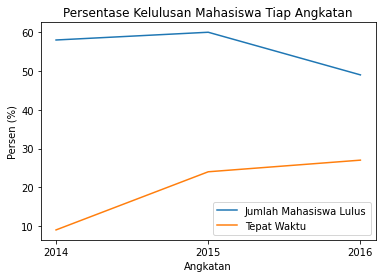

In [15]:
kep_set = set(df2['Keputusan'])

plt.figure()
for kep in kep_set:
     selected_data = df2.loc[df2['Keputusan'] == kep]
     plt.plot(selected_data['Angkatan'], selected_data['Persen'], label=kep)
     
plt.legend()
plt.ylabel('Persen (%)')
plt.xlabel('Angkatan')
plt.title('Persentase Kelulusan Mahasiswa Tiap Angkatan')
plt.show()

In [16]:
# menghapus kolom yang nggak dibutuhkan lagi
df = df.drop('NPM', axis=1)
df = df.drop('Tempat Lahir', axis=1)
df = df.drop('Tanggal Lahir', axis=1)
df = df.drop('Tanggal Yudisium', axis=1)
df = df.drop('Angkatan', axis=1)

##### Organisasi

In [17]:
df['Organisasi'].describe()

count     107
unique      1
top        Ya
freq      107
Name: Organisasi, dtype: object

In [18]:
df['Organisasi'].isnull().sum()

298

In [19]:
df.loc[df['Organisasi'].isna(), 'Organisasi'] = 'Tidak'
df['Organisasi']

0      Tidak
1      Tidak
2      Tidak
3      Tidak
4      Tidak
       ...  
400    Tidak
401    Tidak
402       Ya
403       Ya
404       Ya
Name: Organisasi, Length: 405, dtype: object

<function matplotlib.pyplot.bar>

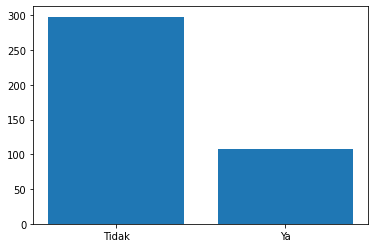

In [20]:
org = df['Organisasi'].groupby(df['Organisasi']).count()

plt.bar(org.index, org)
plt.bar

##### Memperbaiki susunan kolom

In [21]:
df = df[['Jurusan', 'Jenis Kelamin', 'Usia', 'Asal', 'Jalur Masuk', 'Golongan UKT', 'Organisasi', 'IPS 1', 'IPS 2', 'IPS 3', 'IPS 4', 'IPS 5', 'SKS 1', 'SKS 2', 'SKS 3', 'SKS 4', 'SKS 5', 'SKS 6', 'Keputusan']]

In [22]:
# df

##### Menyimpan hasil data preparation

In [23]:
df.to_pickle('data.pkl')

### Data Exploratory

In [24]:
df.isnull().sum()

Jurusan          0
Jenis Kelamin    0
Usia             0
Asal             0
Jalur Masuk      0
Golongan UKT     0
Organisasi       0
IPS 1            0
IPS 2            0
IPS 3            0
IPS 4            0
IPS 5            0
SKS 1            0
SKS 2            0
SKS 3            0
SKS 4            0
SKS 5            0
SKS 6            0
Keputusan        0
dtype: int64

##### Keputusan

In [25]:
df['Keputusan'].value_counts()

Terlambat    273
Tepat        132
Name: Keputusan, dtype: int64

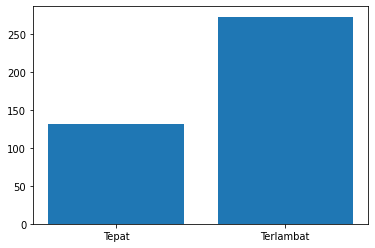

In [26]:
kep = df['Keputusan'].groupby(df['Keputusan']).count()

plt.bar(kep.index, kep)
plt.show()

In [27]:
df['Keputusan'].replace('Terlambat', 0, inplace=True)
df['Keputusan'].replace('Tepat', 1, inplace=True)

In [28]:
def grafik_kelulusan(atribut):
  terlambat = df[df['Keputusan'] == 0][atribut].value_counts()
  tepat = df[df['Keputusan'] == 1][atribut].value_counts()
  data = pd.DataFrame([terlambat, tepat])
  data.index=['Terlambat', 'Tepat']
  data.T.plot(kind='bar', stacked=True, title='Kelulusan')
  return data.head()

##### Jurusan

In [29]:
df['Jurusan'].value_counts()

Informatika         256
Sistem Informasi    149
Name: Jurusan, dtype: int64

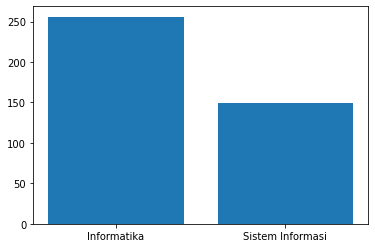

In [30]:
jur = df['Jurusan'].groupby(df['Jurusan']).count()

plt.bar(jur.index, jur)
plt.show()

,Informatika,Sistem Informasi
Terlambat,184,89
Tepat,72,60


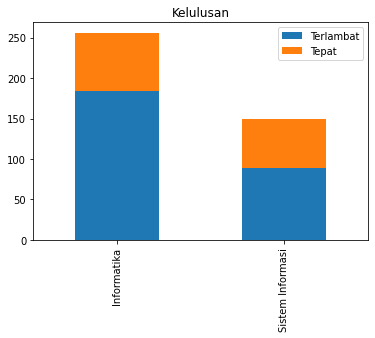

In [31]:
grafik_kelulusan('Jurusan')

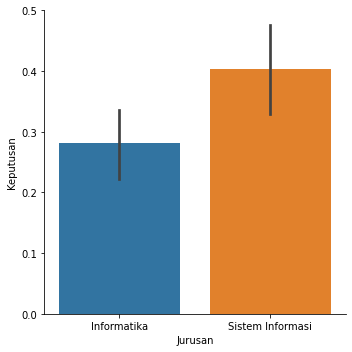

In [32]:
print(sns.catplot(x='Jurusan', y='Keputusan', kind ='bar', data=df))

##### Jenis Kelamin

In [33]:
df['Jenis Kelamin'].value_counts()

Laki-laki    283
Perempuan    122
Name: Jenis Kelamin, dtype: int64

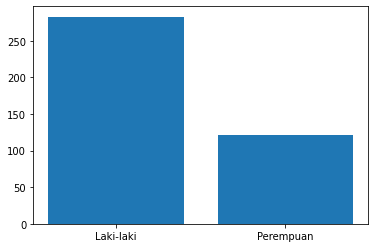

In [34]:
jk = df['Jenis Kelamin'].groupby(df['Jenis Kelamin']).count()

plt.bar(jk.index, jk)
plt.show()

,Laki-laki,Perempuan
Terlambat,221,52
Tepat,62,70


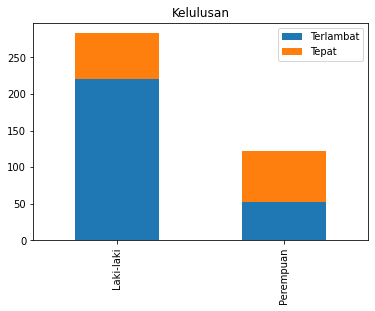

In [35]:
grafik_kelulusan('Jenis Kelamin')

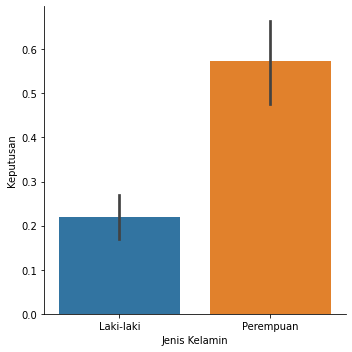

In [36]:
sns.catplot(x='Jenis Kelamin', y='Keputusan', kind ='bar', data=df)

##### Usia

In [37]:
df['Usia'].value_counts().sort_index()

19     20
20    247
21    117
22     17
23      2
24      2
Name: Usia, dtype: int64

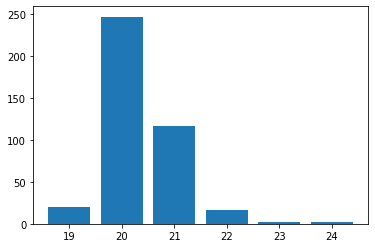

In [38]:
umur = df['Usia'].groupby(df['Usia']).count().sort_values()

plt.bar(umur.index, umur)
plt.show()

,19,20,21,22,23,24
Terlambat,12.0,159.0,84.0,14.0,2.0,2.0
Tepat,8.0,88.0,33.0,3.0,NaN,NaN


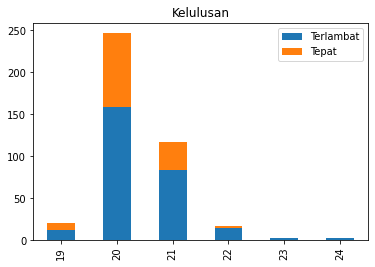

In [39]:
grafik_kelulusan('Usia')

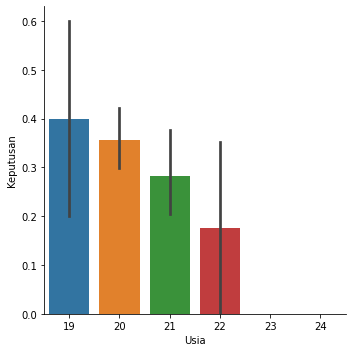

In [40]:
sns.catplot(x='Usia', y='Keputusan', kind='bar', data=df)

##### Asal

In [41]:
df['Asal'].value_counts()

Luar Surabaya    229
Surabaya         176
Name: Asal, dtype: int64

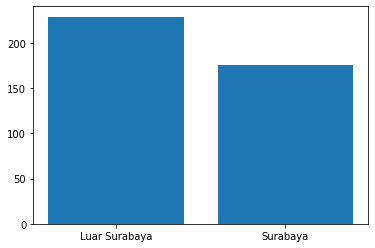

In [42]:
tot_asal = df['Asal'].groupby(df['Asal']).count()

plt.bar(tot_asal.index, tot_asal)
plt.show()

,Luar Surabaya,Surabaya
Terlambat,152,121
Tepat,77,55


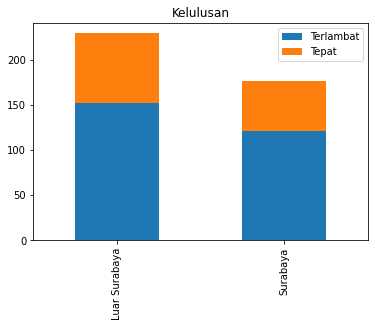

In [43]:
grafik_kelulusan('Asal')

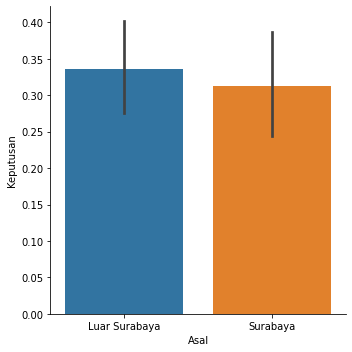

In [44]:
sns.catplot(x='Asal', y='Keputusan', kind='bar', data=df)

##### Jalur Masuk

In [45]:
df['Jalur Masuk'].value_counts()

SBMPTN     193
Mandiri    155
SNMPTN      57
Name: Jalur Masuk, dtype: int64

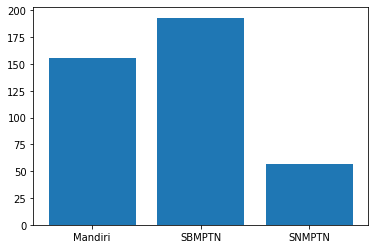

In [46]:
jm = df['Jalur Masuk'].groupby(df['Jalur Masuk']).count()

plt.bar(jm.index, jm)
plt.show()

,SBMPTN,Mandiri,SNMPTN
Terlambat,126,108,39
Tepat,67,47,18


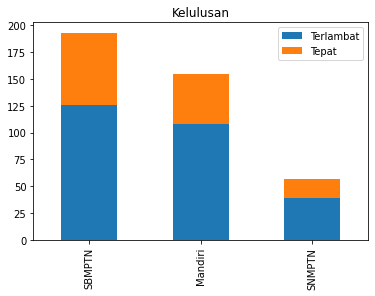

In [47]:
grafik_kelulusan('Jalur Masuk')

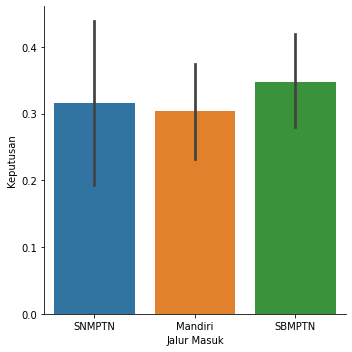

In [48]:
sns.catplot(x='Jalur Masuk', y='Keputusan', kind='bar', data=df)

##### Golongan UKT

In [49]:
df['Golongan UKT'].value_counts()

2    118
1     59
6     53
4     49
3     45
5     44
8     19
7     18
Name: Golongan UKT, dtype: int64

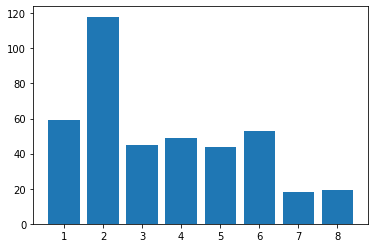

In [50]:
ukt = df['Golongan UKT'].groupby(df['Golongan UKT']).count().sort_values()

plt.bar(ukt.index, ukt)
plt.show()

,1,2,3,4,5,6,7,8
Terlambat,50,91,19,26,27,31,16,13
Tepat,9,27,26,23,17,22,2,6


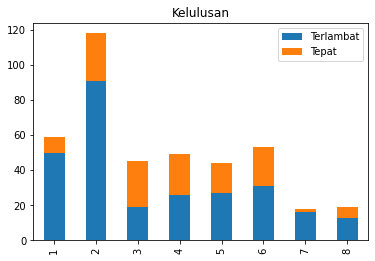

In [51]:
grafik_kelulusan('Golongan UKT')

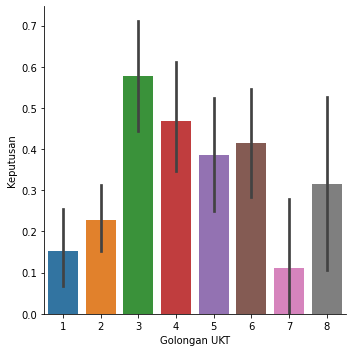

In [52]:
sns.catplot(x='Golongan UKT', y='Keputusan', kind='bar', data=df)

##### Organisasi

In [53]:
df['Organisasi'].value_counts()

Tidak    298
Ya       107
Name: Organisasi, dtype: int64

<function matplotlib.pyplot.bar>

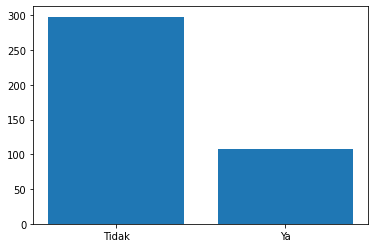

In [54]:
org = df['Organisasi'].groupby(df['Organisasi']).count()

plt.bar(org.index, org)
plt.bar

,Tidak,Ya
Terlambat,215,58
Tepat,83,49


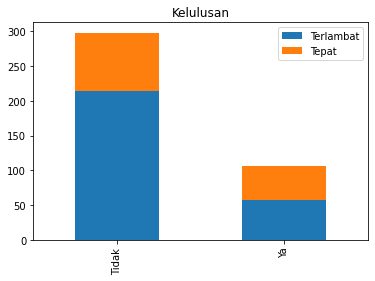

In [55]:
grafik_kelulusan('Organisasi')

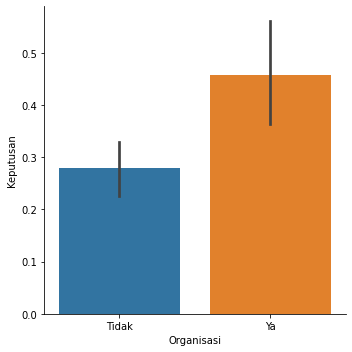

In [56]:
sns.catplot(x='Organisasi', y='Keputusan', kind='bar', data=df)

##### IPS

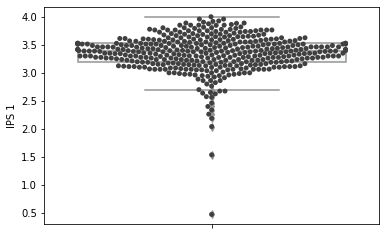

In [57]:
sns.boxplot(y= df['IPS 1'], palette="RdBu"), 
sns.swarmplot(y= df['IPS 1'], color=".25")

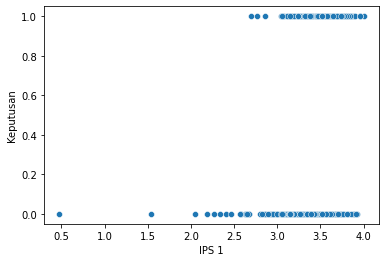

In [58]:
sns.scatterplot(data=df, x=df['IPS 1'], y=df['Keputusan'])

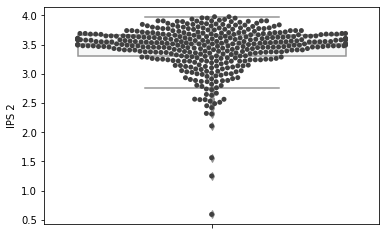

In [59]:
sns.boxplot(y= df['IPS 2'], palette="RdBu"), 
sns.swarmplot(y= df['IPS 2'], color=".25")

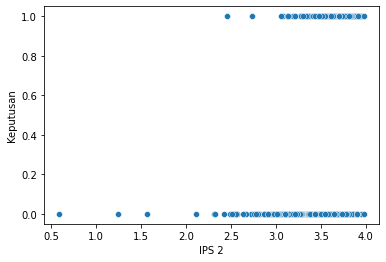

In [60]:
sns.scatterplot(data=df, x=df['IPS 2'], y=df['Keputusan'])

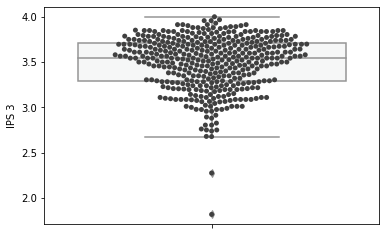

In [61]:
sns.boxplot(y= df['IPS 3'], palette="RdBu"), 
sns.swarmplot(y= df['IPS 3'], color=".25")

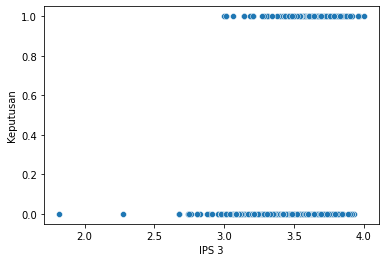

In [62]:
sns.scatterplot(data=df, x=df['IPS 3'], y=df['Keputusan'])

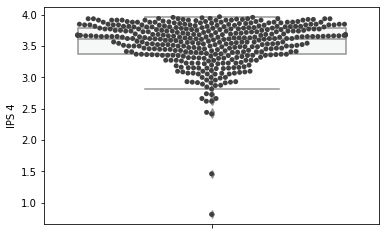

In [63]:
sns.boxplot(y= df['IPS 4'], palette="RdBu"), 
sns.swarmplot(y= df['IPS 4'], color=".25")

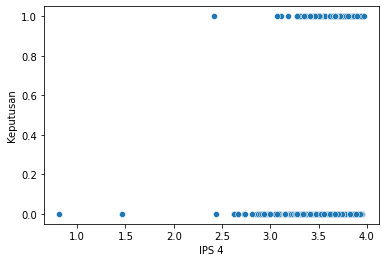

In [64]:
sns.scatterplot(data=df, x=df['IPS 4'], y=df['Keputusan'])

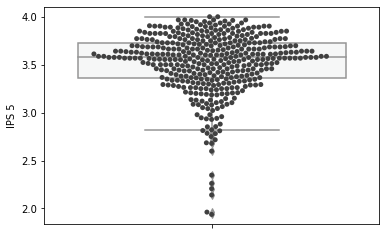

In [65]:
sns.boxplot(y= df['IPS 5'], palette="RdBu"), 
sns.swarmplot(y= df['IPS 5'], color=".25")

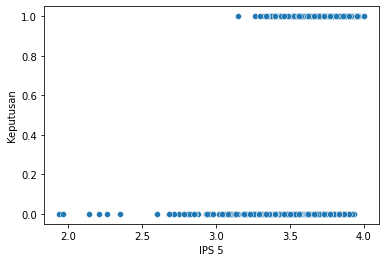

In [66]:
sns.scatterplot(data=df, x=df['IPS 5'], y=df['Keputusan'])

### Correlation

In [67]:
df_encode = df

##### Encoding

In [68]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 373 kB/s 


In [69]:
import category_encoders as ce

encoder= ce.OrdinalEncoder(mapping=[{'col':'Jurusan', 'mapping':{'Informatika':0, 'Sistem Informasi':1}},
                                    {'col':'Jenis Kelamin', 'mapping':{'Laki-laki':0, 'Perempuan':1}},
                                    {'col':'Asal', 'mapping':{'Surabaya':0, 'Luar Surabaya':1}},
                                    {'col':'Jalur Masuk', 'mapping':{'SNMPTN':0,'SBMPTN':1,'Mandiri':2}},
                                    {'col':'Organisasi', 'mapping':{'Ya':0, 'Tidak':1}}
                                    ])

df_encode = encoder.fit_transform(df_encode)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [70]:
df_encode

,Jurusan,Jenis Kelamin,Usia,Asal,Jalur Masuk,Golongan UKT,Organisasi,IPS 1,IPS 2,IPS 3,IPS 4,IPS 5,SKS 1,SKS 2,SKS 3,SKS 4,SKS 5,SKS 6,Keputusan
0,0,0,20,1,0,2,1,3.763,3.896,3.783,3.727,3.761,20,24,23,22,23,19,0
1,0,0,20,0,2,1,1,3.212,3.196,3.391,3.196,3.576,20,23,23,23,23,16,0
2,0,0,20,0,1,2,1,3.375,3.489,3.457,3.533,3.826,20,23,23,23,23,19,0
3,0,0,21,1,1,1,1,3.513,3.641,3.293,3.457,3.674,20,23,23,23,23,19,0
4,0,0,21,0,1,2,1,3.225,3.604,3.435,3.705,3.902,20,24,23,22,23,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1,0,20,0,2,2,1,3.342,3.443,3.217,2.932,3.288,19,22,23,22,20,23,0
401,1,1,20,0,2,2,1,3.145,3.500,3.304,3.000,3.500,19,22,23,22,20,23,0
402,1,0,21,0,2,6,0,3.053,3.216,3.685,3.670,3.563,19,22,23,22,20,23,0
403,1,0,20,0,2,4,0,3.145,3.432,3.489,3.068,3.337,19,22,23,22,23,23,0


##### Correlation

In [71]:
def data_correlation(data):
  correlation = data.corr()
  fig = plt.gcf()
  figsize = fig.get_size_inches()
  fig.set_size_inches(figsize*5)
  sns.heatmap(correlation, annot=True, cbar=True, cmap="RdYlGn")

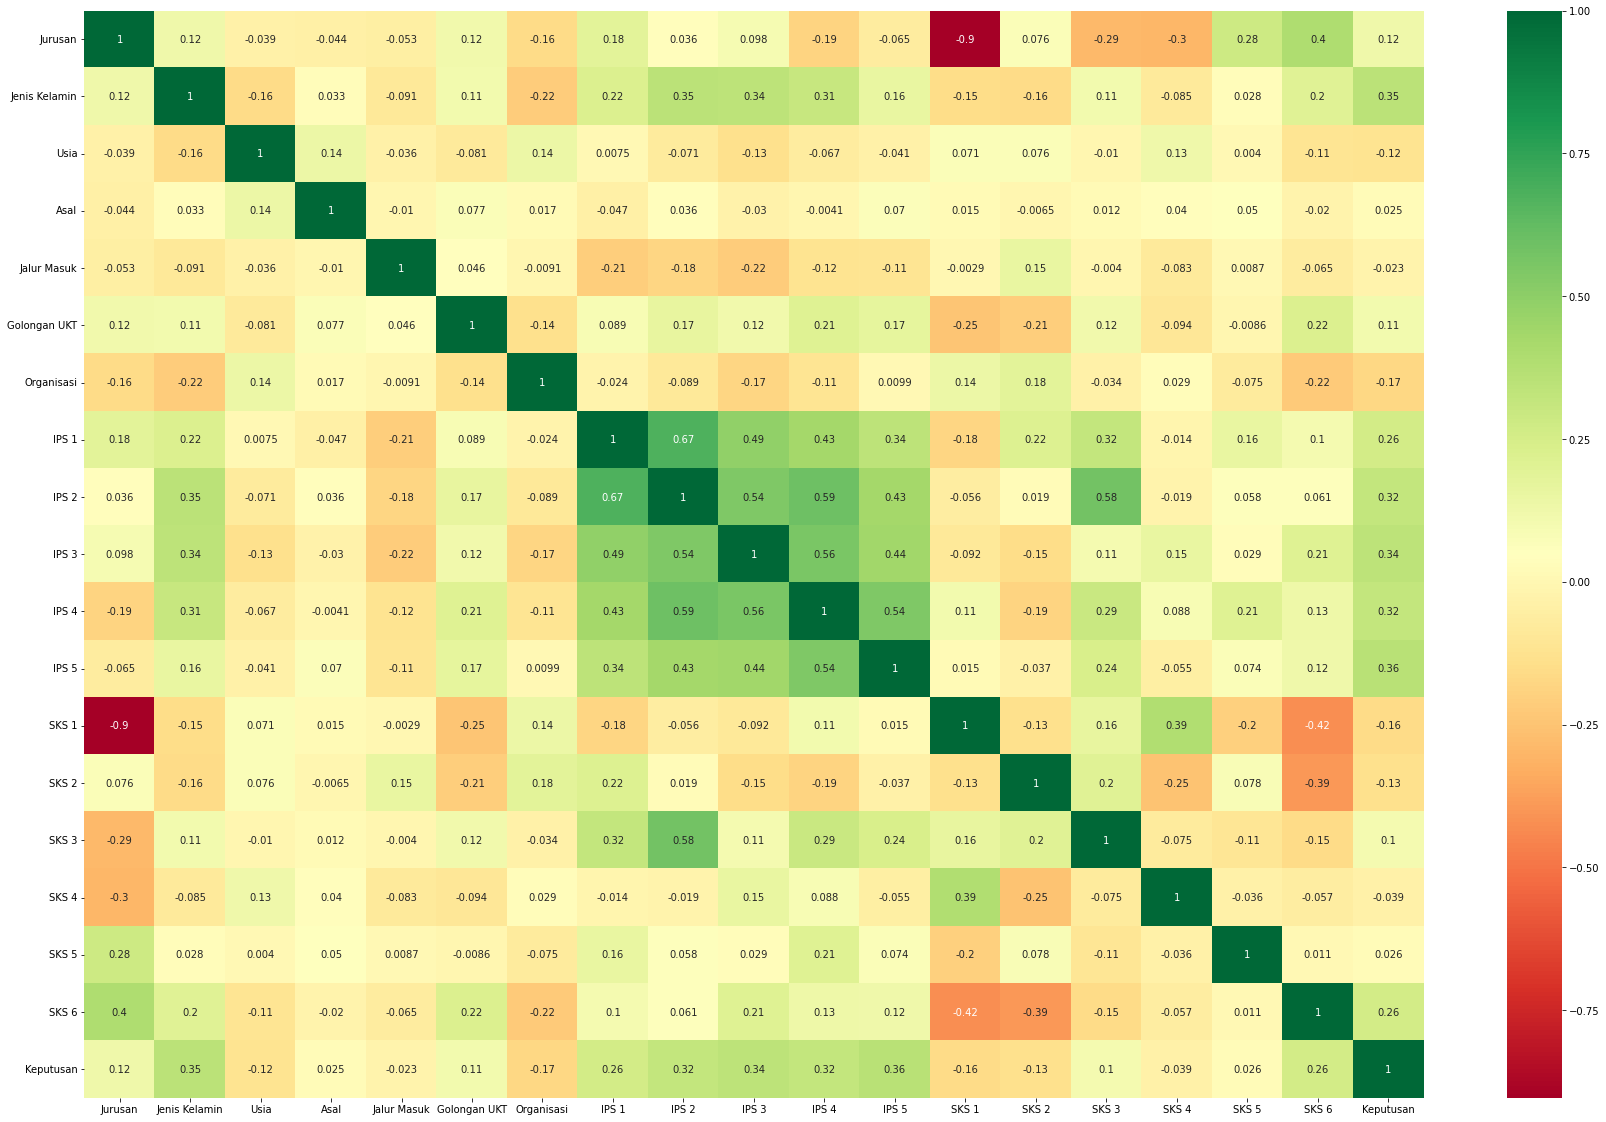

In [72]:
data_correlation(df_encode)

In [73]:
df_encode.corr()

,Jurusan,Jenis Kelamin,Usia,Asal,Jalur Masuk,Golongan UKT,Organisasi,IPS 1,IPS 2,IPS 3,IPS 4,IPS 5,SKS 1,SKS 2,SKS 3,SKS 4,SKS 5,SKS 6,Keputusan
Jurusan,1.000000,0.124056,-0.038652,-0.043893,-0.052974,0.121469,-0.158337,0.183981,0.036358,0.097814,-0.189115,-0.064702,-0.903273,0.076089,-0.292799,-0.298295,0.279711,0.397586,0.124936
Jenis Kelamin,0.124056,1.000000,-0.157161,0.032758,-0.090936,0.112226,-0.216879,0.221903,0.346062,0.342913,0.305261,0.156970,-0.147237,-0.155416,0.112510,-0.085312,0.028310,0.199317,0.347179
Usia,-0.038652,-0.157161,1.000000,0.140770,-0.036239,-0.080647,0.144792,0.007487,-0.071372,-0.134287,-0.066641,-0.040521,0.070996,0.075843,-0.010152,0.127075,0.003953,-0.109770,-0.120954
Asal,-0.043893,0.032758,0.140770,1.000000,-0.010318,0.077128,0.016960,-0.046843,0.035794,-0.030388,-0.004142,0.070268,0.014850,-0.006525,0.012473,0.039996,0.050468,-0.020442,0.025111
Jalur Masuk,-0.052974,-0.090936,-0.036239,-0.010318,1.000000,0.046194,-0.009106,-0.206936,-0.181616,-0.217505,-0.122101,-0.109587,-0.002929,0.153134,-0.004007,-0.082774,0.008721,-0.065012,-0.022720
Golongan UKT,0.121469,0.112226,-0.080647,0.077128,0.046194,1.000000,-0.137076,0.088940,0.165977,0.117189,0.210605,0.172132,-0.246426,-0.206001,0.121286,-0.094036,-0.008583,0.224223,0.108291
Organisasi,-0.158337,-0.216879,0.144792,0.016960,-0.009106,-0.137076,1.000000,-0.023974,-0.088850,-0.174933,-0.110844,0.009902,0.142941,0.184022,-0.033916,0.029303,-0.075034,-0.220184,-0.168773
IPS 1,0.183981,0.221903,0.007487,-0.046843,-0.206936,0.088940,-0.023974,1.000000,0.674442,0.494149,0.432769,0.343795,-0.178651,0.216620,0.321607,-0.013539,0.155131,0.101448,0.262119
IPS 2,0.036358,0.346062,-0.071372,0.035794,-0.181616,0.165977,-0.088850,0.674442,1.000000,0.544360,0.594916,0.431306,-0.055965,0.019396,0.578554,-0.019316,0.057555,0.060944,0.319122
IPS 3,0.097814,0.342913,-0.134287,-0.030388,-0.217505,0.117189,-0.174933,0.494149,0.544360,1.000000,0.555461,0.435816,-0.091982,-0.146486,0.107500,0.152894,0.029450,0.208565,0.344315


In [74]:
df_encode[['IPS 1', 'IPS 2', 'IPS 3', 'IPS 4', 'IPS 5']].corrwith(df_encode['Keputusan'])

IPS 1    0.262119
IPS 2    0.319122
IPS 3    0.344315
IPS 4    0.321323
IPS 5    0.355547
dtype: float64

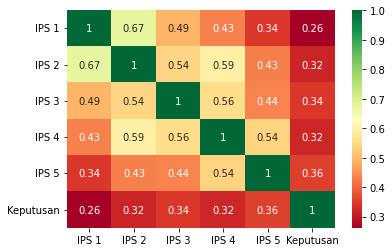

In [75]:
# data_correlation(df_encode[['IPS 1', 'IPS 2', 'IPS 3', 'IPS 4', 'IPS 5', 'Keputusan']])
sns.heatmap(df_encode[['IPS 1', 'IPS 2', 'IPS 3', 'IPS 4', 'IPS 5', 'Keputusan']].corr(), annot=True, cbar=True, cmap="RdYlGn")

In [76]:
df_encode[['SKS 1', 'SKS 2', 'SKS 3', 'SKS 4', 'SKS 5', 'SKS 6']].corrwith(df_encode['Keputusan'])

SKS 1   -0.157248
SKS 2   -0.131250
SKS 3    0.103993
SKS 4   -0.038695
SKS 5    0.025620
SKS 6    0.257722
dtype: float64

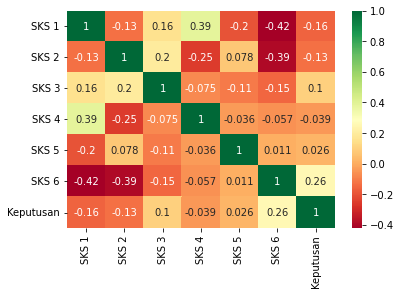

In [77]:
sns.heatmap(df_encode[['SKS 1', 'SKS 2', 'SKS 3', 'SKS 4', 'SKS 5', 'SKS 6', 'Keputusan']].corr(), annot=True, cbar=True, cmap="RdYlGn")

### Modelling dan Evaluation

In [78]:
data = df_encode.drop(columns='Keputusan')
label = df_encode['Keputusan']

In [79]:
data

,Jurusan,Jenis Kelamin,Usia,Asal,Jalur Masuk,Golongan UKT,Organisasi,IPS 1,IPS 2,IPS 3,IPS 4,IPS 5,SKS 1,SKS 2,SKS 3,SKS 4,SKS 5,SKS 6
0,0,0,20,1,0,2,1,3.763,3.896,3.783,3.727,3.761,20,24,23,22,23,19
1,0,0,20,0,2,1,1,3.212,3.196,3.391,3.196,3.576,20,23,23,23,23,16
2,0,0,20,0,1,2,1,3.375,3.489,3.457,3.533,3.826,20,23,23,23,23,19
3,0,0,21,1,1,1,1,3.513,3.641,3.293,3.457,3.674,20,23,23,23,23,19
4,0,0,21,0,1,2,1,3.225,3.604,3.435,3.705,3.902,20,24,23,22,23,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1,0,20,0,2,2,1,3.342,3.443,3.217,2.932,3.288,19,22,23,22,20,23
401,1,1,20,0,2,2,1,3.145,3.500,3.304,3.000,3.500,19,22,23,22,20,23
402,1,0,21,0,2,6,0,3.053,3.216,3.685,3.670,3.563,19,22,23,22,20,23
403,1,0,20,0,2,4,0,3.145,3.432,3.489,3.068,3.337,19,22,23,22,23,23


In [80]:
data.dtypes

Jurusan            int64
Jenis Kelamin      int64
Usia               int64
Asal               int64
Jalur Masuk        int64
Golongan UKT       int64
Organisasi         int64
IPS 1            float64
IPS 2            float64
IPS 3            float64
IPS 4            float64
IPS 5            float64
SKS 1              int64
SKS 2              int64
SKS 3              int64
SKS 4              int64
SKS 5              int64
SKS 6              int64
dtype: object

In [81]:
label

0      0
1      0
2      0
3      0
4      1
      ..
400    0
401    0
402    0
403    0
404    0
Name: Keputusan, Length: 405, dtype: int64

In [82]:
data.describe()

,Jurusan,Jenis Kelamin,Usia,Asal,Jalur Masuk,Golongan UKT,Organisasi,IPS 1,IPS 2,IPS 3,IPS 4,IPS 5,SKS 1,SKS 2,SKS 3,SKS 4,SKS 5,SKS 6
count,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000
mean,0.367901,0.301235,20.358025,0.565432,1.241975,3.560494,0.735802,3.346642,3.433699,3.489812,3.536314,3.518521,19.496296,22.195062,22.533333,22.335802,22.360494,21.219753
std,0.482831,0.459362,0.709006,0.496313,0.682683,2.046349,0.441450,0.338034,0.377587,0.294599,0.344155,0.321496,0.788601,1.275813,1.146238,1.134878,1.526473,2.762659
min,0.000000,0.000000,19.000000,0.000000,0.000000,1.000000,0.000000,0.475000,0.592000,1.818000,0.815000,1.938000,18.000000,15.000000,14.000000,13.000000,13.000000,10.000000
25%,0.000000,0.000000,20.000000,0.000000,1.000000,2.000000,0.000000,3.188000,3.298000,3.293000,3.369000,3.365000,19.000000,21.000000,23.000000,22.000000,22.000000,19.000000
50%,0.000000,0.000000,20.000000,1.000000,1.000000,3.000000,1.000000,3.382000,3.511000,3.543000,3.620000,3.575000,20.000000,22.000000,23.000000,23.000000,23.000000,22.000000
75%,1.000000,1.000000,21.000000,1.000000,2.000000,5.000000,1.000000,3.528000,3.659000,3.707000,3.783000,3.729000,20.000000,23.000000,23.000000,23.000000,23.000000,23.000000
max,1.000000,1.000000,24.000000,1.000000,2.000000,8.000000,1.000000,4.000000,3.976000,4.000000,3.967000,4.000000,21.000000,24.000000,24.000000,24.000000,25.000000,24.000000


#### Skenario 1: NB

In [83]:
X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(
    data,
    label,
    test_size = 0.3,
    random_state=180,
    stratify=label
)

In [84]:
model_s1 = GaussianNB()
model_s1.fit(X_train_s1, y_train_s1)  
prediction_s1 = model_s1.predict(X_test_s1)
  
# print classification report
print('Confusion Matrix \n', confusion_matrix(y_test_s1, prediction_s1))
print('\n Accuracy : ', accuracy_score(y_test_s1, prediction_s1))
print('\n Classification Report \n', classification_report(y_test_s1, prediction_s1))
print('AUC : ', roc_auc_score(y_test_s1, prediction_s1))

Confusion Matrix 
 [[54 28]
 [ 8 32]]

 Accuracy :  0.7049180327868853

 Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.66      0.75        82
           1       0.53      0.80      0.64        40

    accuracy                           0.70       122
   macro avg       0.70      0.73      0.70       122
weighted avg       0.76      0.70      0.71       122

AUC :  0.7292682926829268


#### Skenario 2: NB + SMOTE

In [85]:
from sklearn.preprocessing import StandardScaler

data_s2 = StandardScaler().fit_transform(data)
print(data_s2)

[[-0.76290973 -0.65657856 -0.50559183 ... -0.29625903  0.41946194
  -0.80447822]
 [-0.76290973 -0.65657856 -0.50559183 ...  0.58598294  0.41946194
  -1.89173187]
 [-0.76290973 -0.65657856 -0.50559183 ...  0.58598294  0.41946194
  -0.80447822]
 ...
 [ 1.31077107 -0.65657856  0.90657846 ... -0.29625903 -1.54828422
   0.64519332]
 [ 1.31077107 -0.65657856 -0.50559183 ... -0.29625903  0.41946194
   0.64519332]
 [ 1.31077107  1.52304699 -0.50559183 ... -0.29625903  0.41946194
  -0.44206033]]


In [86]:
X_train_s2, X_test_s2, y_train_s2, y_test_s2 = train_test_split(
    data_s2,
    label,
    test_size = 0.3,
    random_state=180,
    stratify=label
)

In [87]:
print("Sebelum SMOTE, label '0': {}".format(sum(y_train_s2 == 0)))
print("Sebelum SMOTE, label '1': {} \n".format(sum(y_train_s2 == 1)))
  
# apply SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_smote, y_train_smote = sm.fit_sample(X_train_s2, y_train_s2)

print("Sesudah SMOTE, label '0': {}".format(sum(y_train_smote == 0)))
print("Sesudah SMOTE, label '1': {}".format(sum(y_train_smote == 1)))


Sebelum SMOTE, label '0': 191
Sebelum SMOTE, label '1': 92 

Sesudah SMOTE, label '0': 191
Sesudah SMOTE, label '1': 191


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [88]:
model_s2 = GaussianNB()
model_s2.fit(X_train_smote, y_train_smote)  
prediction_s2 = model_s2.predict(X_test_s2)
  
# print classification report
print('Confusion Matrix \n', confusion_matrix(y_test_s2, prediction_s2))
print('\n Accuracy : ', accuracy_score(y_test_s2, prediction_s2))
print('\n Classification Report \n', classification_report(y_test_s2, prediction_s2))
print('AUC : ', roc_auc_score(y_test_s2, prediction_s2))

Confusion Matrix 
 [[51 31]
 [ 5 35]]

 Accuracy :  0.7049180327868853

 Classification Report 
               precision    recall  f1-score   support

           0       0.91      0.62      0.74        82
           1       0.53      0.88      0.66        40

    accuracy                           0.70       122
   macro avg       0.72      0.75      0.70       122
weighted avg       0.79      0.70      0.71       122

AUC :  0.7484756097560976


#### Skenario 3: NB + PCA

PCA:
1. Normalisasi data
2. Hitung Covarian Matrix
3. Hitung eigenvalue
4. Hitung eigenvector
5. Tentukan komponen baru



##### Standarisasi

In [89]:
from sklearn.preprocessing import StandardScaler

data_s3 = StandardScaler().fit_transform(data)
data_s3 = pd.DataFrame(data_s3)
print(data_s3)

           0         1         2   ...        15        16        17
0   -0.762910 -0.656579 -0.505592  ... -0.296259  0.419462 -0.804478
1   -0.762910 -0.656579 -0.505592  ...  0.585983  0.419462 -1.891732
2   -0.762910 -0.656579 -0.505592  ...  0.585983  0.419462 -0.804478
3   -0.762910 -0.656579  0.906578  ...  0.585983  0.419462 -0.804478
4   -0.762910 -0.656579  0.906578  ... -0.296259  0.419462 -1.891732
..        ...       ...       ...  ...       ...       ...       ...
400  1.310771 -0.656579 -0.505592  ... -0.296259 -1.548284  0.645193
401  1.310771  1.523047 -0.505592  ... -0.296259 -1.548284  0.645193
402  1.310771 -0.656579  0.906578  ... -0.296259 -1.548284  0.645193
403  1.310771 -0.656579 -0.505592  ... -0.296259  0.419462  0.645193
404  1.310771  1.523047 -0.505592  ... -0.296259  0.419462 -0.442060

[405 rows x 18 columns]


In [90]:
import pickle

std_filename = 'scaler.pkl'
pickle.dump(data_s3, open(std_filename, 'wb'))

##### Covarian Matrix

In [91]:
# Menghitung Covariance Matrix

data_s3_mean = np.mean(data_s3, axis=0)
cov_mat = (data_s3 - data_s3_mean).T.dot((data_s3 - data_s3_mean)) / (data_s3.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
          0         1         2   ...        15        16        17
0   1.002475  0.124363 -0.038748  ... -0.299033  0.280403  0.398570
1   0.124363  1.002475 -0.157550  ... -0.085524  0.028380  0.199811
2  -0.038748 -0.157550  1.002475  ...  0.127390  0.003963 -0.110041
3  -0.044001  0.032840  0.141119  ...  0.040095  0.050593 -0.020492
4  -0.053105 -0.091161 -0.036329  ... -0.082979  0.008743 -0.065173
5   0.121769  0.112504 -0.080847  ... -0.094268 -0.008605  0.224778
6  -0.158729 -0.217416  0.145150  ...  0.029375 -0.075219 -0.220729
7   0.184436  0.222452  0.007505  ... -0.013572  0.155515  0.101699
8   0.036448  0.346918 -0.071549  ... -0.019364  0.057697  0.061095
9   0.098056  0.343762 -0.134620  ...  0.153272  0.029523  0.209082
10 -0.189583  0.306016 -0.066806  ...  0.087803  0.210043  0.135001
11 -0.064863  0.157358 -0.040621  ... -0.055195  0.073806  0.123545
12 -0.905509 -0.147601  0.071172  ...  0.386787 -0.198834 -0.421608
13  0.076277 -0.155801  0.076

##### Eigenvalue, Eigenvector

In [92]:
# Menghitung Eigen Value dan Eigen Vector

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)


Eigenvectors 
[[-9.79019986e-02 -5.50368383e-01 -1.32444370e-01  7.03516624e-01
   1.74700043e-01  1.95536206e-02  3.64406851e-02  1.22074620e-01
   9.44939278e-02  3.00605356e-01  9.83345267e-02  5.90026980e-02
   2.25361467e-02  6.65156292e-02  9.98058472e-03  5.14154657e-02
   8.78977900e-02 -7.41850076e-03]
 [-2.68616039e-01 -7.30152535e-02  1.24371137e-01  8.75975301e-03
  -1.52853911e-01 -2.19473875e-02  1.00282948e-01 -3.40834877e-02
   3.98369074e-02 -1.48786535e-01  2.81303384e-01 -2.07884537e-02
   4.37200020e-01 -2.58103281e-01  1.79349890e-01  3.13749189e-01
  -3.24303117e-01 -5.24478931e-01]
 [ 8.67550117e-02  8.75666608e-02 -1.13633503e-01 -2.10029929e-02
   4.36294220e-01  3.50702290e-02 -3.86093545e-01 -7.30877705e-02
  -4.43133184e-02  3.27401940e-02 -5.46926118e-02  2.21787365e-01
   9.26269802e-02  4.54463287e-01  1.64348733e-01  9.17372606e-02
  -5.65123485e-01 -1.83140805e-02]
 [-4.93071868e-03  3.57164014e-02  6.59993506e-03  3.26946275e-02
   1.43699648e-01 -6.51

In [93]:
# Membuat tuple eigenvalue, eigenvector menjadi berpasangan
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Mengurutkan pasangan eigenvalue, eigenvector dari tinggi ke rendah
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Ngeprint eigenvalue dari tinggi ke rendah
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
3.6749304543703154
2.641142468782359
1.8277074359683705
1.3248666702300738
1.1699950594462307
1.054730857044203
0.9629141406711705
0.879613840329956
0.7858300026654923
0.7360568595083337
0.6922243006798076
0.6123114974341037
0.43362575800845654
0.4065665027988336
0.33381619509512767
0.273561845268443
0.1756349404097771
0.05902562673449818


In [94]:
# Menghitung jumlah variasi data berdasarkan jumlah komponennya

tot = sum(eig_vals) # tot berjumlah 100
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([ 20.36586973,  35.00265379,  45.13151255,  52.47370919,
        58.95763243,  64.80278011,  70.13909442,  75.01377194,
        79.36871462,  83.44782259,  87.28401762,  90.67734882,
        93.08043258,  95.33355833,  97.18351365,  98.69954912,
        99.67288953, 100.        ])

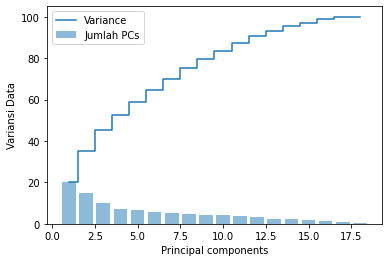

In [95]:
plt.bar(range(1,19), var_exp, alpha=0.5, align='center', label='Jumlah PCs')
plt.step(range(1,19),cum_var_exp, where= 'mid', label='Variance')
plt.ylabel('Variansi Data')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()

##### Menentukan komponen baru

In [96]:
# Perhitungan matematika

eigvectors_sorted= [eig_pairs[index][1] for index in range(len(eig_vals))]

D_reduce = np.array(eigvectors_sorted[0:14])   # Mengurangi dari 18 menjadi 14 dimensi
data_D = np.dot(data_s3,D_reduce.T)   # memproyeksikan data asli ke dalam dimensi komponen utama
data_reduced_pca = pd.DataFrame(data_D)  # convert ke dataframe baru

data_reduced_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.501513,1.763439,-1.662613,1.238733,0.491996,0.251041,0.236397,-1.379098,-0.842083,0.860429,0.804697,0.027146,-0.445357,-0.413395
1,1.884344,1.488483,-1.172314,-0.279449,1.242215,-1.201270,-0.517666,0.148995,0.360473,0.249135,0.021979,0.183743,0.723251,0.804238
2,0.168572,1.541274,-0.749098,0.313932,1.168349,-0.491612,-0.955038,-0.162503,-0.443674,0.107066,0.281436,-0.078834,0.858234,0.126353
3,0.496967,1.742001,-1.220448,1.331746,-0.454709,-0.071884,0.447140,-0.178627,-0.055085,-0.049047,0.402211,-0.656836,0.304316,0.013271
4,0.298060,1.952945,-1.955467,0.518006,0.567167,-0.471204,-0.800445,-0.060174,-0.608857,-1.062983,0.384532,0.932640,0.533296,0.563651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1.499090,-1.351521,-0.632539,-1.067715,1.123746,1.438754,-0.512204,0.804790,1.000058,0.328447,0.116232,-1.236834,0.201255,0.699569
401,0.659517,-1.373098,-0.187708,-1.449121,1.189992,1.277914,0.157373,-0.038778,1.762638,-0.593612,-0.699817,-0.648194,1.149772,0.775002
402,-0.178007,-1.354005,0.704433,-1.418681,-0.325174,0.671026,-0.543859,2.124325,0.371204,-0.631552,1.269949,1.055643,0.025055,0.666912
403,0.518217,-2.016608,0.064749,-1.233500,0.657003,-0.624680,0.188095,1.565568,-0.281268,0.224694,0.747762,-0.392335,0.309151,0.736749


In [97]:
# menyimpan weight untuk data selanjutnya
import pickle

red_filename = 'reduce.pkl'
pickle.dump(D_reduce, open(red_filename, 'wb'))


In [98]:
X_train_s3, X_test_s3, y_train_s3, y_test_s3 = train_test_split(
    data_reduced_pca,
    label,
    test_size = 0.3,
    random_state=180,
    stratify=label
)

In [99]:
model_s3 = GaussianNB()
model_s3.fit(X_train_s3, y_train_s3)
prediction_s3 = model_s3.predict(X_test_s3)

In [100]:
print("Confusion Matrix \n",confusion_matrix(y_test_s3,prediction_s3))
print("\n Accuracy",accuracy_score(y_test_s3,prediction_s3))
print("\n Classification Report \n",classification_report(y_test_s3,prediction_s3))
print("\n ROC AUC",roc_auc_score(y_test_s3,prediction_s3))

Confusion Matrix 
 [[68 14]
 [11 29]]

 Accuracy 0.7950819672131147

 Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.83      0.84        82
           1       0.67      0.72      0.70        40

    accuracy                           0.80       122
   macro avg       0.77      0.78      0.77       122
weighted avg       0.80      0.80      0.80       122


 ROC AUC 0.7771341463414634


#### Skenario 4: NB + SMOTE + PCA

In [101]:
from sklearn.preprocessing import StandardScaler

data_s4 = StandardScaler().fit_transform(data)
print(data_s4)

[[-0.76290973 -0.65657856 -0.50559183 ... -0.29625903  0.41946194
  -0.80447822]
 [-0.76290973 -0.65657856 -0.50559183 ...  0.58598294  0.41946194
  -1.89173187]
 [-0.76290973 -0.65657856 -0.50559183 ...  0.58598294  0.41946194
  -0.80447822]
 ...
 [ 1.31077107 -0.65657856  0.90657846 ... -0.29625903 -1.54828422
   0.64519332]
 [ 1.31077107 -0.65657856 -0.50559183 ... -0.29625903  0.41946194
   0.64519332]
 [ 1.31077107  1.52304699 -0.50559183 ... -0.29625903  0.41946194
  -0.44206033]]


In [102]:
X_train_s4, X_test_s4, y_train_s4, y_test_s4 = train_test_split(
    data_s4,
    label,
    test_size = 0.3,
    random_state=180,
    stratify=label
)

##### SMOTE

In [103]:
# apply SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_smote_s4, y_train_smote_s4 = sm.fit_sample(X_train_s4, y_train_s4)

print("Setelah SMOTE, label '0': {}".format(sum(y_train_smote_s4 == 0)))
print("Setelah SMOTE, label '1': {}".format(sum(y_train_smote_s4 == 1)))


Setelah SMOTE, label '0': 191
Setelah SMOTE, label '1': 191


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


##### Covarian Matrix

In [104]:
# Menghitung Covariance Matrix

data_s4_mean = np.mean(X_train_smote_s4, axis=0)
cov_mat = (X_train_smote_s4 - data_s4_mean).T.dot((X_train_smote_s4 - data_s4_mean)) / (X_train_smote_s4.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00551399e+00  1.53022866e-01 -3.52445832e-02 -3.69890137e-02
  -2.59069453e-02  1.55041274e-01 -1.34652634e-01  9.09649046e-02
   6.00711701e-03  2.24525796e-02 -2.04155618e-01 -6.83588041e-02
  -9.32591720e-01  7.74048188e-02 -2.50808220e-01 -3.76520299e-01
   2.80557075e-01  4.08205219e-01]
 [ 1.53022866e-01  1.04240450e+00 -1.14853174e-01 -3.62095478e-02
  -3.65871096e-02  1.81987783e-01 -3.52977517e-01  1.97191569e-01
   3.25036792e-01  3.09773392e-01  2.97906181e-01  1.37895320e-01
  -1.91660433e-01 -2.04151022e-01  1.05166616e-01 -8.40091966e-02
  -5.05996998e-03  2.71623146e-01]
 [-3.52445832e-02 -1.14853174e-01  8.97907585e-01  1.47606128e-01
  -7.78483945e-02 -3.95210168e-02  1.49898433e-01 -5.53420158e-04
  -5.39593377e-02 -1.13583909e-01 -5.84936378e-02 -3.04961644e-02
   8.78840908e-02  3.20284147e-02 -5.60285577e-02  7.60859081e-02
  -3.64567591e-03 -1.19077107e-01]
 [-3.69890137e-02 -3.62095478e-02  1.47606128e-01  9.75875605e-01
  -1.28904057e-01 

##### Eigenvalue, Eigenvector

In [105]:
# Menghitung Eigen Value dan Eigen Vector

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)


Eigenvectors 
[[ 1.27600234e-01  5.30607718e-01 -1.46577179e-01 -1.71637464e-01
  -6.93992147e-01  3.30999414e-02 -1.18793903e-01 -8.28521000e-02
   1.90689914e-01 -2.64874969e-01  7.30451178e-04  8.97940340e-02
  -8.16576309e-02 -1.33208849e-01 -3.22054593e-02 -8.59509134e-02
   9.81926097e-03  3.68024410e-03]
 [ 3.14753201e-01  6.84556717e-02  1.39155536e-01  1.71974137e-01
  -1.20416869e-02 -2.39161587e-02  5.65842580e-02  3.33225184e-02
  -2.45741651e-01 -7.24722994e-02 -4.57909837e-01  5.11415590e-03
  -8.43180680e-02 -8.08240082e-02  8.47926090e-02  2.25731037e-01
   6.43575883e-01  2.84518355e-01]
 [-9.21856926e-02 -6.06569192e-02 -5.23435190e-02 -3.90062481e-01
   2.96428542e-02 -1.36257584e-02  6.53020532e-02  6.04491331e-02
   5.76993464e-02  1.07189791e-03 -5.47404784e-02 -5.10677206e-01
  -4.20425732e-01  1.15460869e-01  9.63832979e-02 -2.44955438e-01
  -6.14164012e-02  5.41921725e-01]
 [-1.87858642e-02 -6.02553488e-02 -5.26609551e-02 -4.96432730e-01
  -4.92024093e-02 -3.60

In [106]:
# Membuat tuple eigenvalue, eigenvector menjadi berpasangan
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Mengurutkan pasangan eigenvalue, eigenvector dari tinggi ke rendah
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Ngeprint eigenvalue dari tinggi ke rendah
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
3.459069262353263
2.7332266182220306
1.8432671623137584
1.3262301659142213
0.9476296834527308
0.88118663320406
0.8030043154958127
0.749504801856658
0.680143916709423
0.6354268725011191
0.582732279924806
0.5674237961513556
0.3905790289011323
0.3591770503049582
0.25897945228038927
0.24198192225199622
0.15741672229176149
0.05661133647851499


In [107]:
# Menghitung jumlah variasi data berdasarkan jumlah komponennya

tot = sum(eig_vals) # tot berjumlah 100
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([ 20.7457965 ,  37.13834574,  48.19335579,  56.14743217,
        61.83084903,  67.11577315,  71.93179817,  76.42695942,
        80.50612818,  84.3171061 ,  87.81204777,  91.21517668,
        93.55767763,  95.71184496,  97.26507637,  98.71636495,
        99.66047304, 100.        ])

##### Menentukan komponen baru

In [108]:
# Perhitungan matematika

eigvectors_sorted= [eig_pairs[index][1] for index in range(len(eig_vals))]

D_reduce_s4 = np.array(eigvectors_sorted[0:11])   # Mengurangi dari 18 menjadi 11 dimensi

data_D_s4 = np.dot(X_train_smote_s4,D_reduce_s4.T)   # memproyeksikan data asli ke dalam dimensi komponen utama

data_reduced_pca_s4 = pd.DataFrame(data_D_s4)  # convert ke dataframe baru

data_reduced_pca_s4

,0,1,2,3,4,5,6,7,8,9,10
0,-1.410408,2.053645,0.383173,-0.605073,-2.101688,1.244599,-0.630383,-0.764653,-1.184869,-0.239870,-1.701708
1,1.446924,-1.875505,0.368764,-1.682319,0.458449,-0.104261,0.028509,-0.123347,0.080060,-1.056497,-0.858873
2,2.799612,1.027663,0.539569,-0.452766,-1.764066,1.968430,0.781551,-0.696862,-0.232774,0.648641,0.578549
3,2.123281,-0.917044,1.690514,0.299121,-1.590415,-0.102649,0.133348,-0.424132,0.007397,0.056329,-0.414090
4,-2.045603,-0.344590,0.219690,-0.126238,0.065396,-0.125784,0.561871,-1.447018,0.297840,-0.456071,0.994665
...,...,...,...,...,...,...,...,...,...,...,...
377,0.942759,1.193467,-0.420899,-0.442723,1.459491,1.102513,-0.369569,-0.174729,-0.065667,-0.359462,-0.317491
378,-2.019076,-0.576188,-0.551564,1.443514,0.758056,0.624219,0.579386,0.524761,-0.023952,-0.245200,-0.087295
379,0.952372,1.027177,-0.458672,-1.377651,0.984257,0.919983,-0.243447,0.006346,-0.257845,-0.149855,-0.058445
380,1.979691,-1.082529,1.963592,2.197307,-0.316472,-0.194747,0.193593,0.434518,0.404621,-1.166226,0.634168


##### Predict

In [109]:
predict_s4 = np.dot(X_test_s4,D_reduce_s4.T)   # memproyeksikan data asli ke dalam dimensi 10 komponen utama
reduced_new = pd.DataFrame(predict_s4)  # convert ke dataframe baru
reduced_new

,0,1,2,3,4,5,6,7,8,9,10
0,-0.787964,-1.858532,-0.427725,-1.980048,-0.091040,-2.218227,-1.274240,0.941022,0.200882,-1.641105,0.711340
1,0.804460,-1.022954,1.397935,0.218990,1.881410,0.420423,-0.022086,-0.282801,-0.164794,-0.074016,0.047211
2,-1.114018,-1.463846,-1.049802,-0.139304,0.620511,0.706889,-0.949971,1.006022,-0.292307,-0.208948,-0.260790
3,2.435865,-1.053907,2.094818,1.764242,-1.044316,-0.456462,1.783605,-1.112933,0.533527,-0.601166,0.273372
4,0.622381,-2.212294,-2.533122,0.459238,0.719537,1.521431,-0.183964,0.479908,-0.287049,-0.056604,0.002659
...,...,...,...,...,...,...,...,...,...,...,...
117,1.141286,-0.768172,1.687634,1.723097,0.720049,-0.054300,0.863146,0.721043,-1.679588,-0.486279,-0.228873
118,-1.786365,1.340924,3.899658,0.718320,0.477773,1.104512,2.099421,2.286631,-1.559436,-1.044761,0.498163
119,1.492107,1.523961,-1.207022,-0.174837,1.621864,0.873186,-0.466588,-0.701144,0.294746,-0.893015,0.641150
120,-0.311074,-1.121306,-0.547797,1.006170,-1.419665,-0.383837,0.218313,-0.848654,2.237047,-0.670266,0.152352


In [110]:
model_s4 = GaussianNB()
model_s4.fit(data_reduced_pca_s4, y_train_smote_s4)  
prediction_s4 = model_s4.predict(reduced_new)
  
# print classification report
print('Confusion Matrix \n', confusion_matrix(y_test_s4, prediction_s4))
print('\n Accuracy \n', accuracy_score(y_test_s4, prediction_s4))
print('\n Classification Report \n', classification_report(y_test_s4, prediction_s4))
print('AUC : ', roc_auc_score(y_test_s4, prediction_s4))

Confusion Matrix 
 [[57 25]
 [ 9 31]]

 Accuracy 
 0.7213114754098361

 Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.70      0.77        82
           1       0.55      0.78      0.65        40

    accuracy                           0.72       122
   macro avg       0.71      0.74      0.71       122
weighted avg       0.76      0.72      0.73       122

AUC :  0.735060975609756


### Save and Load Model

In [111]:
import pickle

model_filename = 'pca_model.pkl'
pickle.dump(model_s3, open(model_filename, 'wb'))


In [112]:
# load the model from disk
loaded_model = pickle.load(open(model_filename, 'rb'))

### Predict New Data

In [113]:
new_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SKRIPSI/Data Validasi.csv')

In [114]:
new_df

,Jurusan,Jenis Kelamin,Usia,Asal,Jalur Masuk,Golongan UKT,Organisasi,IPS 1,IPS 2,IPS 3,IPS 4,IPS 5,SKS 1,SKS 2,SKS 3,SKS 4,SKS 5,SKS 6
0,Sistem Informasi,Laki-laki,22,Luar Surabaya,SNMPTN,4,Ya,3.816,3.576,3.772,3.837,3.837,19,23,23,23,23,23
1,Sistem Informasi,Perempuan,20,Luar Surabaya,SNMPTN,4,Ya,3.526,3.304,3.598,3.815,3.772,19,23,23,23,23,23
2,Sistem Informasi,Perempuan,21,Surabaya,SNMPTN,4,Ya,3.618,3.152,3.620,3.630,3.707,19,23,23,23,23,23
3,Sistem Informasi,Perempuan,20,Luar Surabaya,SNMPTN,5,Tidak,3.776,3.500,3.598,3.739,3.446,19,23,23,23,23,23
4,Sistem Informasi,Perempuan,21,Luar Surabaya,SNMPTN,6,Tidak,3.803,3.511,3.489,3.804,3.837,19,23,23,23,23,23
5,Sistem Informasi,Perempuan,21,Luar Surabaya,Mandiri,6,Ya,3.842,3.467,3.859,3.859,3.641,19,23,23,23,23,23
6,Sistem Informasi,Perempuan,22,Surabaya,Mandiri,5,Ya,3.421,3.337,3.522,3.641,3.576,19,23,23,23,23,23
7,Informatika,Laki-laki,22,Luar Surabaya,SNMPTN,3,Tidak,3.583,3.583,3.641,3.837,3.875,21,21,23,23,24,23
8,Informatika,Perempuan,20,Luar Surabaya,SNMPTN,3,Tidak,3.643,3.845,3.652,3.891,3.844,21,21,23,23,24,23
9,Informatika,Laki-laki,21,Luar Surabaya,SBMPTN,3,Tidak,3.964,4.000,3.924,4.000,3.969,21,21,23,23,24,23


In [115]:
new_df.shape

(15, 18)

In [116]:
# digunakan hanya di notebook

encoder= ce.OrdinalEncoder(mapping=[{'col':'Jurusan', 'mapping':{'Informatika':0, 'Sistem Informasi':1}},
                                    {'col':'Jenis Kelamin', 'mapping':{'Laki-laki':0, 'Perempuan':1}},
                                    {'col':'Asal', 'mapping':{'Surabaya':0, 'Luar Surabaya':1}},
                                    {'col':'Jalur Masuk', 'mapping':{'SNMPTN':0,'SBMPTN':1,'Mandiri':2}},
                                    {'col':'Organisasi', 'mapping':{'Ya':0, 'Tidak':1}}
                                    ])

new_df = encoder.fit_transform(new_df)

In [117]:
pickle.dump(encoder, open('encoder.pkl', 'wb'))

In [118]:
new_df

,Jurusan,Jenis Kelamin,Usia,Asal,Jalur Masuk,Golongan UKT,Organisasi,IPS 1,IPS 2,IPS 3,IPS 4,IPS 5,SKS 1,SKS 2,SKS 3,SKS 4,SKS 5,SKS 6
0,1,0,22,1,0,4,0,3.816,3.576,3.772,3.837,3.837,19,23,23,23,23,23
1,1,1,20,1,0,4,0,3.526,3.304,3.598,3.815,3.772,19,23,23,23,23,23
2,1,1,21,0,0,4,0,3.618,3.152,3.620,3.630,3.707,19,23,23,23,23,23
3,1,1,20,1,0,5,1,3.776,3.500,3.598,3.739,3.446,19,23,23,23,23,23
4,1,1,21,1,0,6,1,3.803,3.511,3.489,3.804,3.837,19,23,23,23,23,23
5,1,1,21,1,2,6,0,3.842,3.467,3.859,3.859,3.641,19,23,23,23,23,23
6,1,1,22,0,2,5,0,3.421,3.337,3.522,3.641,3.576,19,23,23,23,23,23
7,0,0,22,1,0,3,1,3.583,3.583,3.641,3.837,3.875,21,21,23,23,24,23
8,0,1,20,1,0,3,1,3.643,3.845,3.652,3.891,3.844,21,21,23,23,24,23
9,0,0,21,1,1,3,1,3.964,4.000,3.924,4.000,3.969,21,21,23,23,24,23


In [119]:
# gunakan load pickle

# pertama
# scaler.pkl
normalize = pickle.load(open('scaler.pkl', 'rb'))
new_df = normalize.transform(new_df)
new_df

In [119]:
# kedua
# reduce.pkl
reduce_D = pickle.load(open('reduce.pkl', 'rb'))

new_df = np.dot(new_df,reduce_D.T)

In [119]:
# ketiga
# pca_model.pkl
model = pickle.load(open('pca_model.pkl', 'rb'))
model.predict(new_df)